In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv('data/split/train.csv')

In [3]:
df_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,119191.0,2.052427,-0.133236,-1.740621,0.277935,0.337999,-0.826933,0.334629,-0.227039,0.267655,0.293539,0.427682,0.504109,-0.989043,0.761661,-0.984511,-0.296433,-0.336666,-0.231668,0.544180,-0.269148,-0.006518,0.121300,0.037733,-0.356498,0.147822,0.569149,-0.103929,-0.091958,8.73,0
1,71750.0,1.220356,-0.159191,-0.444349,-0.094437,0.104457,-0.345790,0.170867,-0.094996,0.187572,-0.143353,-0.947576,-0.541060,-0.817426,0.564658,1.276676,0.046158,-0.176105,-0.676223,0.038731,-0.033806,-0.088775,-0.364654,-0.140851,-0.707308,0.415661,1.087767,-0.102532,-0.008335,59.95,0
2,151977.0,0.892824,-1.440698,-0.637940,3.912871,0.099291,2.433288,-0.308891,0.603227,-0.113826,1.057386,-1.317899,-0.768390,-1.081373,0.133451,0.447815,0.575453,-0.158101,-0.903597,-2.798035,0.509795,0.484969,0.487304,-0.122694,-0.598803,-0.594563,0.062841,-0.033426,0.038254,460.65,0
3,55709.0,-3.146021,2.247634,0.901397,0.146162,-2.109360,-0.148312,-1.533191,2.073663,0.499394,-0.363315,-1.072917,0.252020,-1.155591,0.742563,0.338738,0.094420,0.990406,-0.371517,-0.390559,-0.096924,0.050567,-0.037019,0.107000,0.392857,0.303597,0.379544,-0.148990,0.074965,4.78,0
4,66654.0,1.194996,-0.007495,0.301285,0.750199,-0.297494,-0.405836,0.060410,-0.150482,0.400860,-0.228237,-1.002326,0.639557,0.671282,-0.212945,-0.237918,-0.161859,-0.182514,-0.619759,0.389821,0.011447,-0.234931,-0.545566,-0.089418,-0.064036,0.527305,0.294221,-0.025980,0.015637,44.31,0


In [4]:
df_train.isna().sum().sum() # no missing values

0

   Class     ratio   count
0      0  0.998215  170579
1      1  0.001785     305


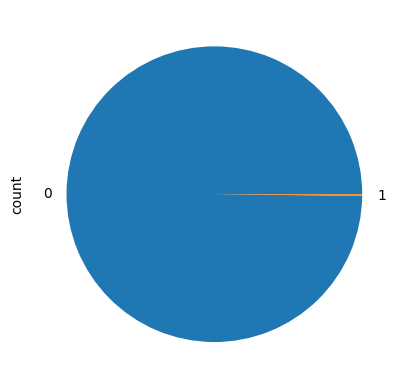

In [5]:
# check class imbalance
num_rows = df_train.shape[0]
class_count = df_train["Class"].value_counts().to_dict()

class_stat = pd.DataFrame({
    "Class": class_count.keys(),
    "ratio": [i / num_rows for i in class_count.values()],
    "count": class_count.values()
})

print(class_stat)
df_train["Class"].value_counts().plot(kind="pie")
plt.show()

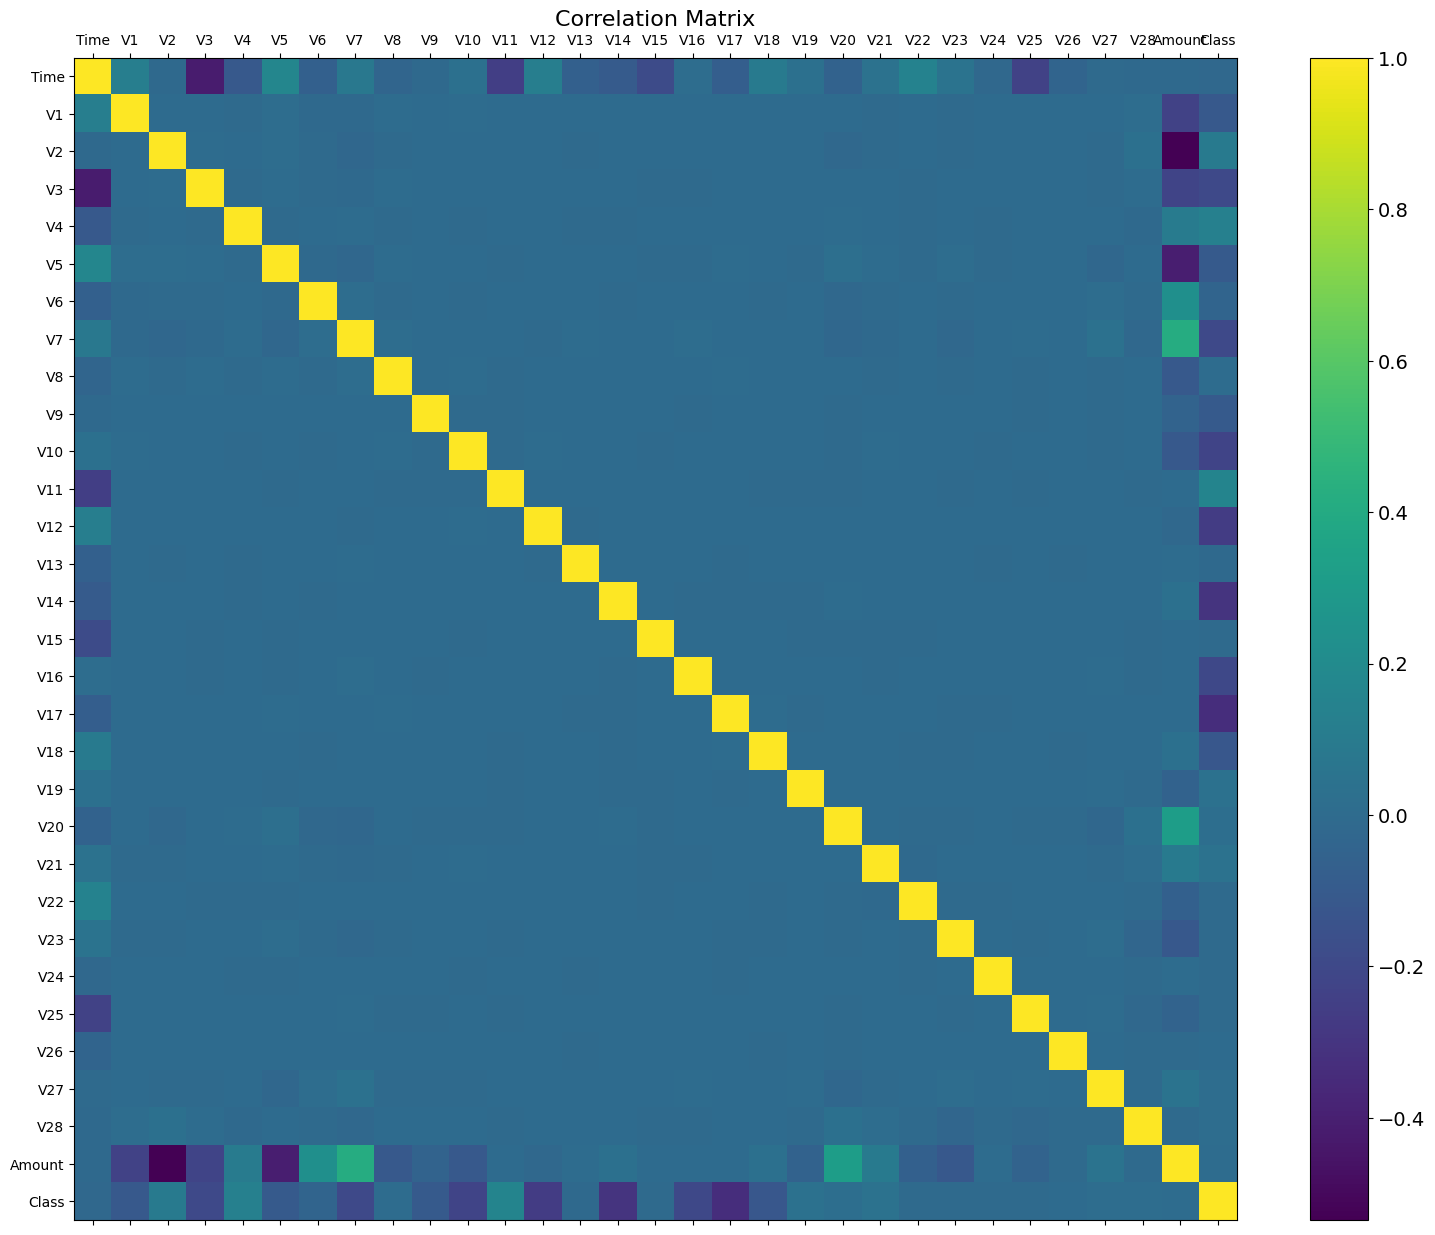

In [6]:
# plot correlation matrix
corr = df_train.corr()
f = plt.figure(figsize=(19, 15))
plt.matshow(corr, fignum=f.number)
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

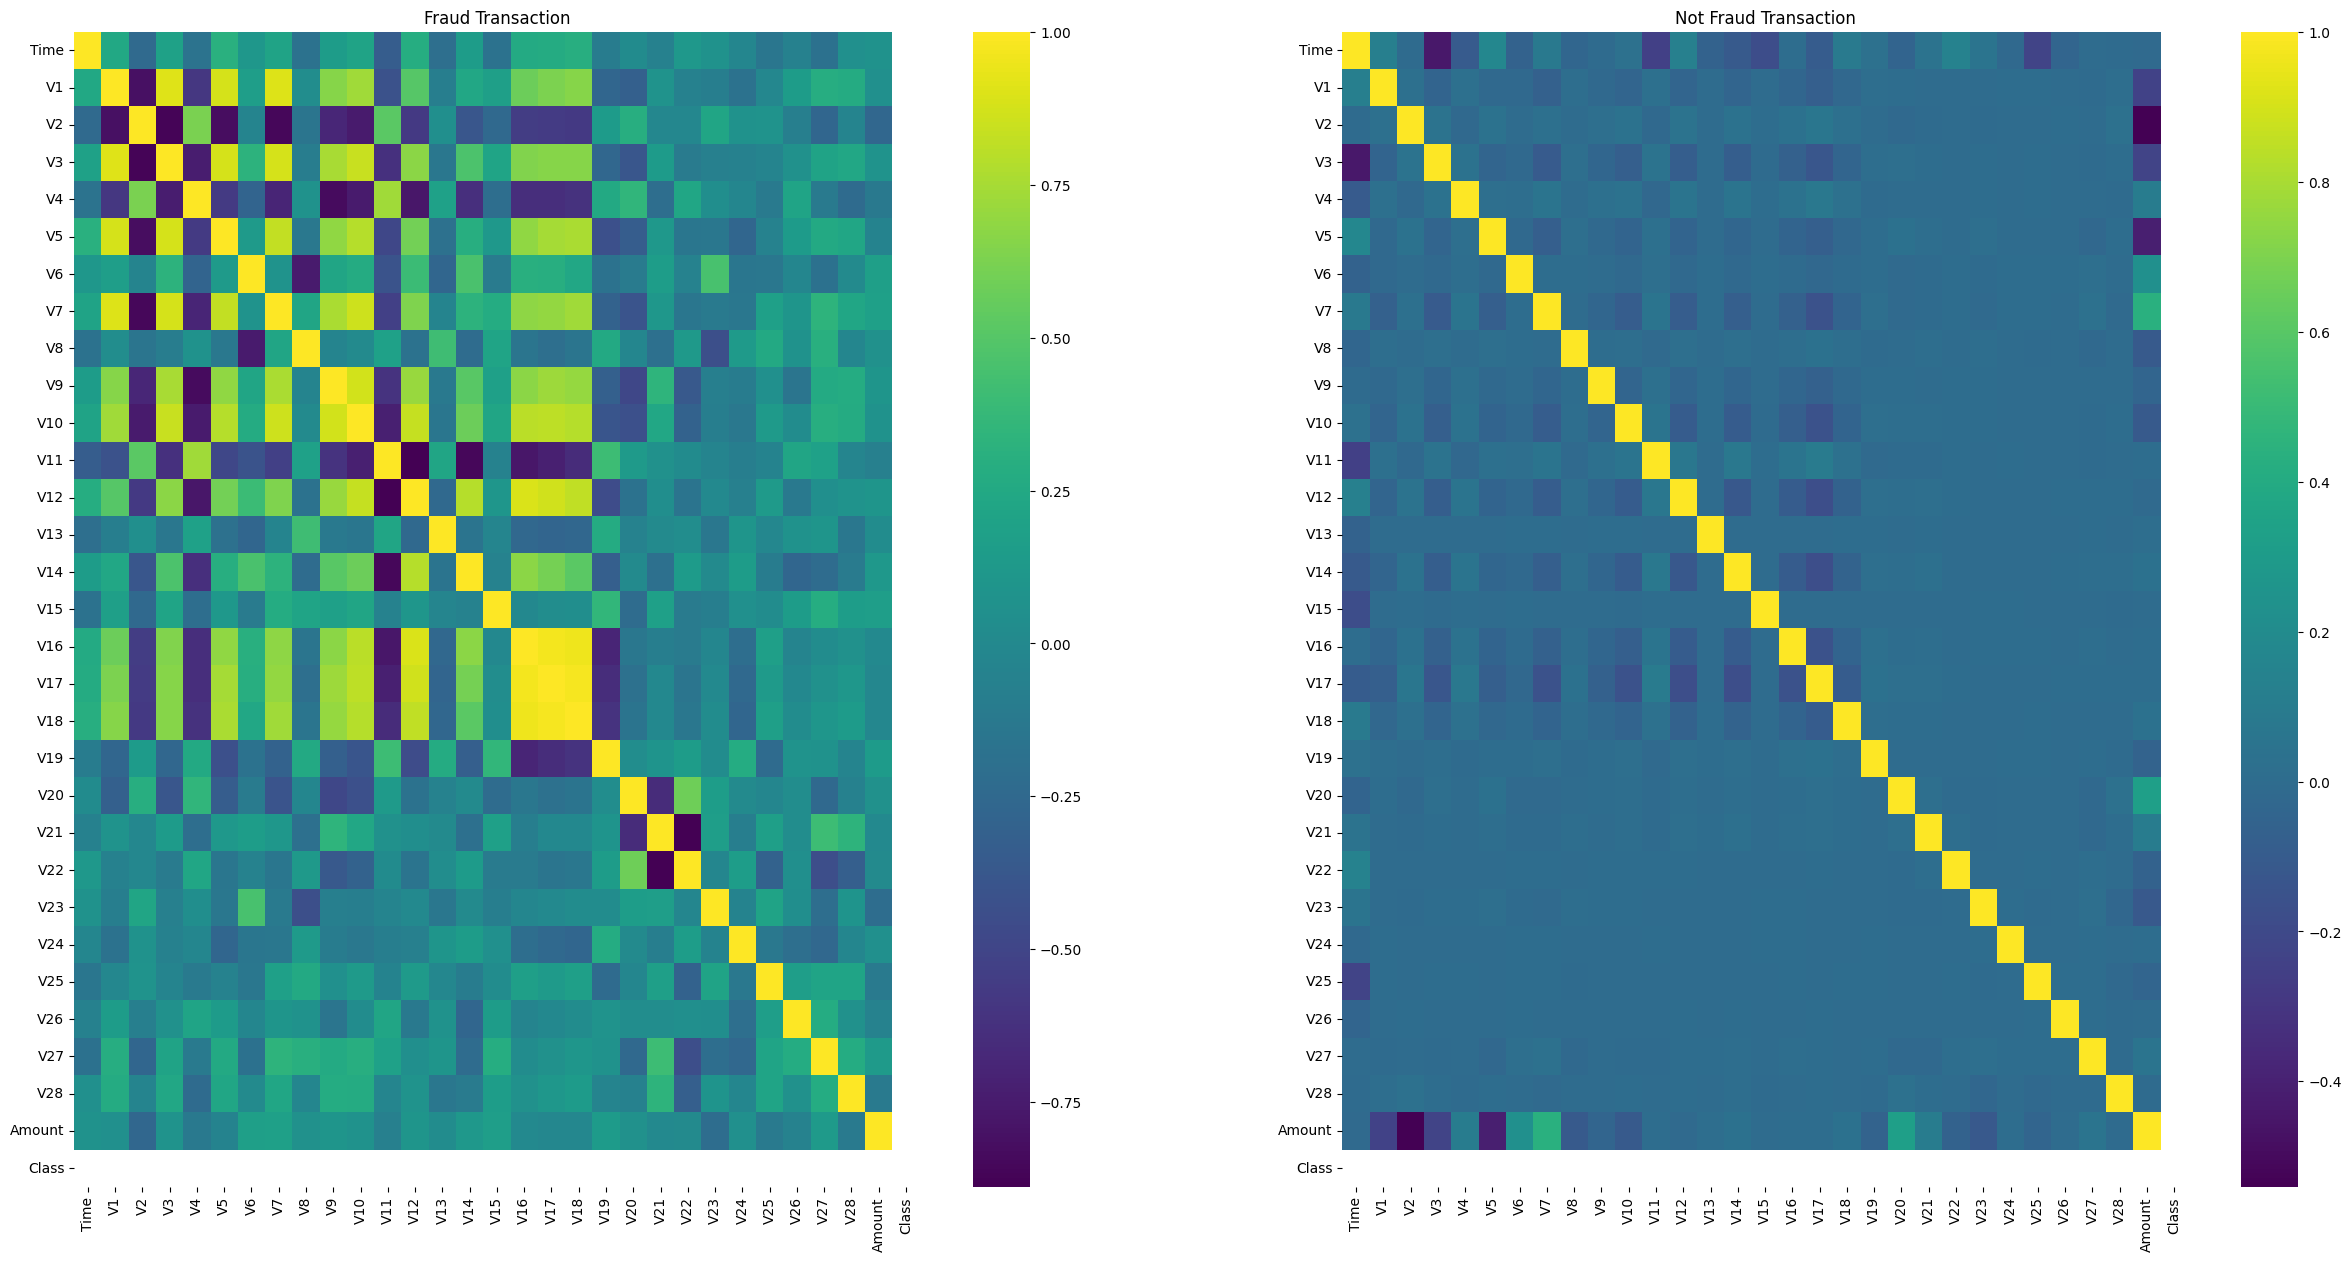

In [7]:
# plot the subplot of the fraud and normal transactions correlation matrix separately

fraud_transaction = df_train[df_train['Class'] == 1]
not_fraud_transaction = df_train[df_train['Class'] == 0]

f = plt.figure(figsize=(30, 15))
plt.subplot(1, 2, 1)
sns.heatmap(fraud_transaction.corr(), cmap='viridis', annot=False)
plt.title('Fraud Transaction')
plt.subplot(1, 2, 2)
sns.heatmap(not_fraud_transaction.corr(), cmap='viridis', annot=False)
plt.title('Not Fraud Transaction')
plt.show()


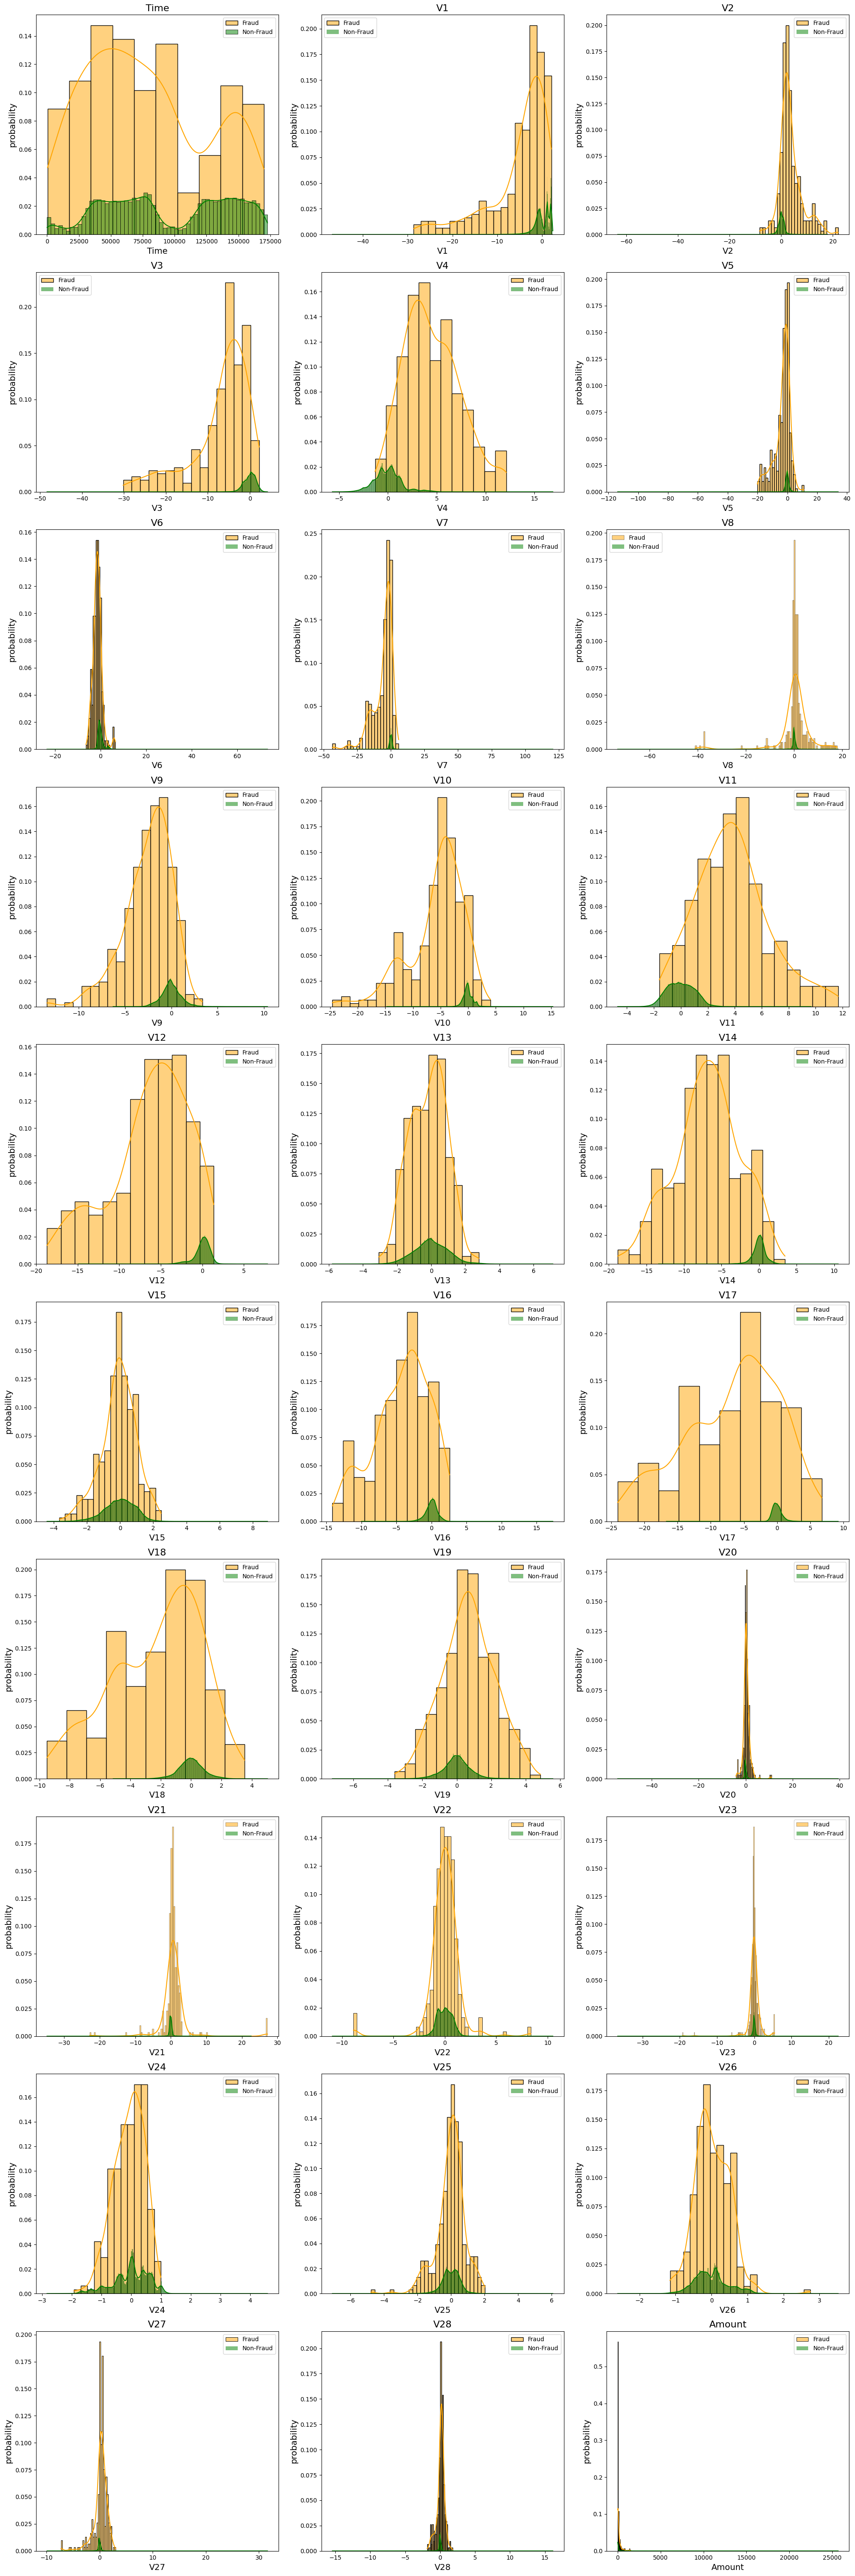

In [8]:
# plot distribution of each feature for fraud and non-fraud transactions
# kde - kernel density estimation

fraud_records = df_train['Class'] == 1
unfraud_records = df_train['Class'] == 0

figure = plt.figure(figsize=(20, 60))
for i, col in enumerate(df_train.columns.to_list()):
    if col == 'Class': continue
    plt.subplot(10, 3, i + 1)
    sns.histplot(df_train[col][fraud_records], color='orange', label='Fraud',stat='probability', kde=True, fill=True, alpha=0.5) 
    sns.histplot(df_train[col][unfraud_records], color='green', label='Non-Fraud',stat='probability', kde=True, fill=True, alpha=0.5)
    plt.title(col, fontsize=16)
    plt.xlabel(col, fontsize=14)
    plt.ylabel('probability', fontsize=14)
    plt.legend()
plt.tight_layout()
plt.show()

* According to distributions above:
    * Time: Both classes are somewhat evenly distributed, with fraud transactions peaking earlier than non-fraud.
    * V1 to V28: The distributions vary significantly between fraud and non-fraud transactions. 
    * Amount: Non-fraud transactions show a higher density for smaller amounts, while fraud transactions have a broader spread.

#### Boxplot

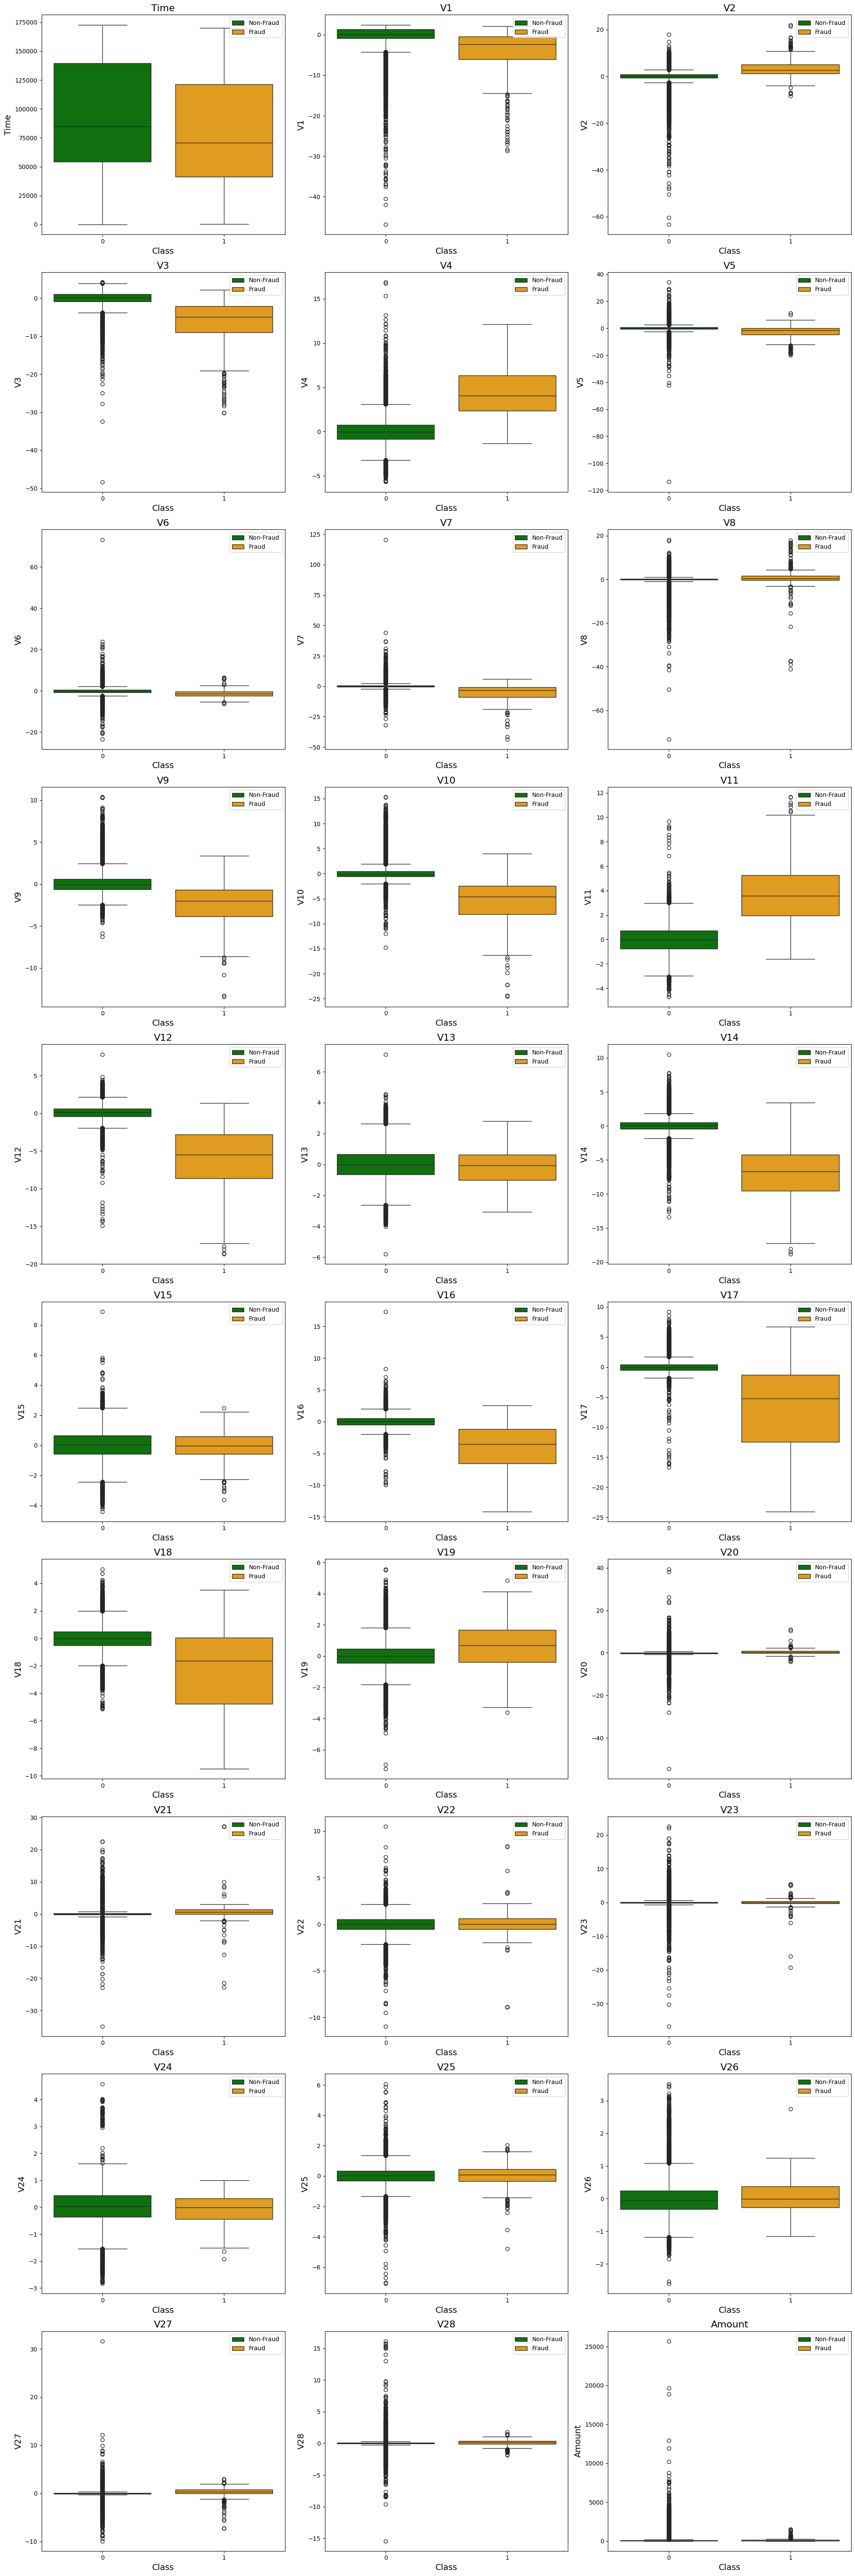

In [9]:
figure = plt.figure(figsize=(20, 60))
for i, col in enumerate(df_train.columns.to_list()):
    if col == 'Class':
        continue
    plt.subplot(10, 3, i + 1)
    sns.boxplot(x='Class', y=col, data=df_train, hue='Class', palette=['green', 'orange'])
    plt.title(col, fontsize=16)
    plt.xlabel('Class', fontsize=14)
    plt.ylabel(col, fontsize=14)
    plt.legend(labels=['Non-Fraud', 'Fraud'], loc='upper right')
plt.tight_layout()
plt.show()

#### PCA for visualization

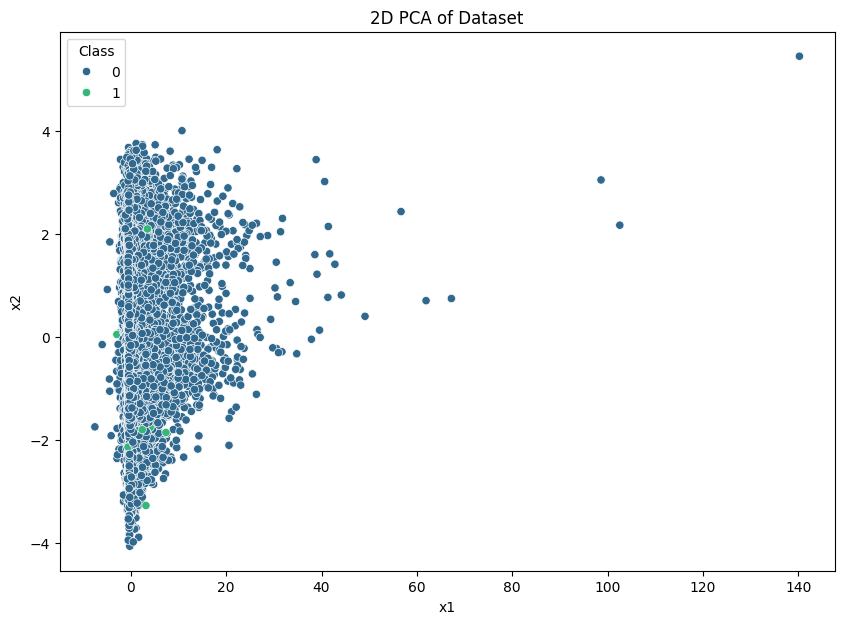

In [10]:
# plot 2D PCA

X = df_train.drop('Class', axis=1)  
y = df_train['Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])


plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue=y, data=principal_df, palette='viridis')
plt.title('2D PCA of Dataset')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

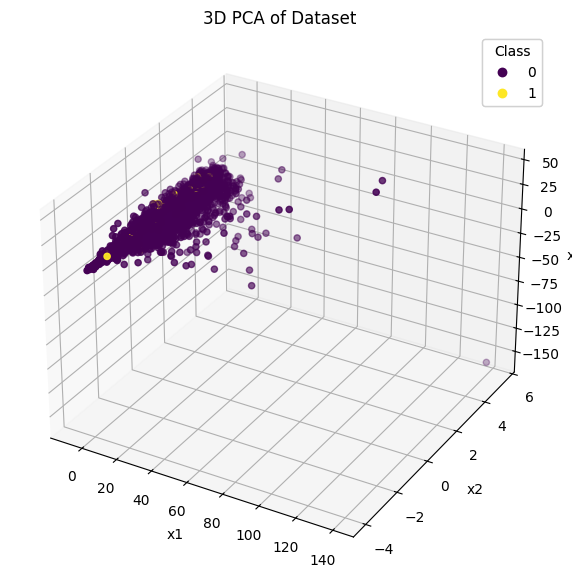

In [11]:
# plot 3D PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X=X_scaled)
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')


scatter = ax.scatter(principal_df['PC1'], principal_df['PC2'], principal_df['PC3'], c=y, cmap='viridis')

ax.set_title('3D PCA of Dataset')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')


legend = ax.legend(*scatter.legend_elements(), title="Class")
ax.add_artist(legend)

plt.show()

* Using PCA here is not useful we cannot figure out a decision boundary or geometric relationship with this low dimensions.

#### Feature importance using random forest

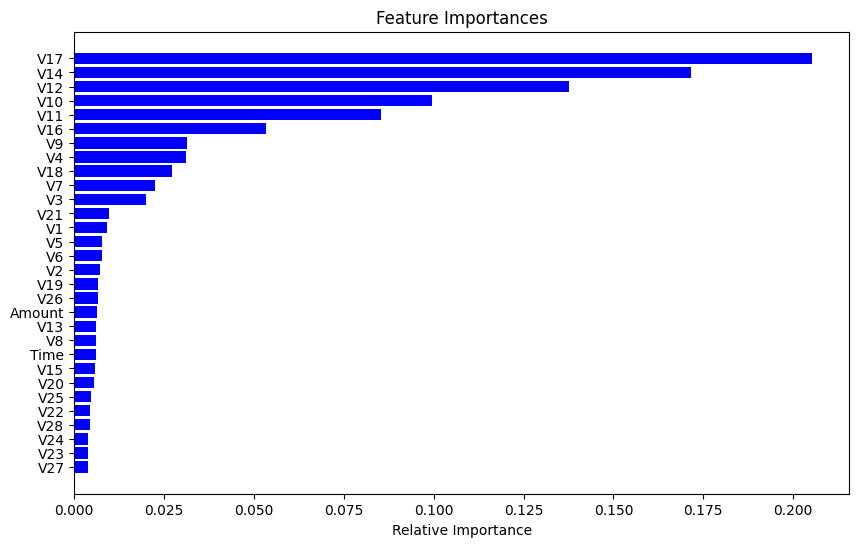

In [13]:
# feature importance by random forest
from cradit_fraud_utils_helper import load_model

model_path = 'models/2024_07_18_07_29/trained_models.pkl' 
model = load_model(model_path) 

rf = model['Random_forest']['model']

importances = rf.feature_importances_
feature_names = df_train.columns

indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()